# 步骤：

1. 观察每个sector在naive method下的正确率
2. 将有数据的划分为train set，没有数据的作为predire set
3. 使用kfold划分train set为train和test（validation）两部分（（如果三个attr都有bay且邻居有bay，如果两个attr都有bay且邻居有bay，如果一个attr都有bay且邻居有bay，如果三个attr都有bay，如果两个attr都有bay，如果一个attr有bay， 1； 如果没有attr有bay， 0））
4. 将在bay area的输出为1， 非bay area的输出为0
5. 使用KNN为没有数据的部分进行填补
6. 使用louvain重新进行填补（通过louvain对有信息的数据进行划分社区，再通过knn预测未知数据？）
7. 和naive method做对比，比较正确率
8. 寻找最有影响力的五个人（在bay area）（betweeness centrality？pagerank？）
9. 和原始数据进行对比

In [2]:
# -*- coding: utf-8 -*-
"""
Created on Wed Jul 26 16:09:11 2017

@author: cbothore
"""


import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import pylab
import numpy as np
import pickle
from collections import Counter

In [3]:
def properties(g):
    """
    Computes simple and classic graph metrics.

    Parameters
    ----------
    g : graph
       A networkx graph
    """
    # networkx short summary of information for the graph g
    print(nx.info(g))
    
    # Draw the degree distribution. Powerlow distribution for a real (complex) network
    plt.figure(num=None)
    fig = plt.figure(1)
    degree_sequence=[d for n, d in g.degree()] # degree sequence
    print("Degree sequence %s" % degree_sequence)
    plt.hist(degree_sequence, bins='auto')  
    plt.title("powerlaw degree distribution")
    plt.ylabel("# nodes")
    plt.xlabel("degree")
    plt.show()
    pylab.close()
    del fig
    
# 偏心率：节点A的偏心率被定义为A和所有其他节点之间的最大距离。 可以使用nx.eccentricity（）函数找到它。 
# 如果偏心率为1，则他与所有人相连
    precomputed_eccentricity = nx.eccentricity(g) # costly step, we save time here!
    print("Graph density %f" % nx.density(g))
    print("Diameter (maximum eccentricity): %d" % nx.diameter(g,precomputed_eccentricity))
    print("Radius (minimum eccentricity): %d" % nx.radius(g,precomputed_eccentricity)) #The radius is the minimum eccentricity.
    print("Mean eccentricity (eccentricity(v) = the maximum distance from v to all other nodes): %s" % np.mean(list(precomputed_eccentricity.values())))
    print("Center is composed of %d nodes (nodes with eccentricity equal to radius)" % len(nx.center(g, precomputed_eccentricity)))
    print("Periphery is composed of %d nodes (nodes with eccentricity equal to the diameter)" % len(nx.periphery(g,precomputed_eccentricity)))
    
# 聚类系数：据观察，在社交网络中共享联系的人倾向于形成关联。换句话说，社交网络中存在形成集群的趋势。
# 我们可以确定节点的集群，Local Clustering Coefficient，它是节点的朋友（即连接）彼此连接的对的一部分。
# 为了确定局部聚类系数，我们使用nx.clustering（Graph，Node）函数。
    print("Mean clustering coefficient %f" % np.mean(list(nx.clustering(g).values())))
    total_triangles=sum(nx.triangles(g).values())/3    
    print("Total number of triangles in graph: %d" % total_triangles)

In [4]:
def naive_method(graph, empty, attr):
    """   Predict the missing attribute with a simple but effective
    relational classifier. 
    
    The assumption is that two connected nodes are 
    likely to share the same attribute value. Here we chose the most frequently
    used attribute by the neighbors
    
    Parameters
    ----------
    graph : graph
       A networkx graph
    empty : list
       The nodes with empty attributes 
    attr : dict 
       A dict of attributes, either location, employer or college attributes. 
       key is a node, value is a list of attribute values.

    Returns
    -------
    predicted_values : dict 
       A dict of attributes, either location, employer or college attributes. 
       key is a node (from empty), value is a list of attribute values. Here 
       only 1 value in the list.
     """
    predicted_values={}
    for n in empty:
        nbrs_attr_values=[] #一个空的列表
        for nbr in graph.neighbors(n): #遍历图的节点
            if nbr in attr: 
                for val in attr[nbr]:
                    nbrs_attr_values.append(val)
        predicted_values[n]=[]
        if nbrs_attr_values: # non empty list
            # count the number of occurrence each value and returns a dict
            cpt=Counter(nbrs_attr_values)
            # take the most represented attribute value among neighbors
            a,nb_occurrence=max(cpt.items(), key=lambda t: t[1])
            predicted_values[n].append(a)
       
    return predicted_values

In [10]:
def evaluation_accuracy(groundtruth, pred):
    """    Compute the accuracy of your model.

     The accuracy is the proportion of true results.

    Parameters
    ----------
    groundtruth :  : dict 
       A dict of attributes, either location, employer or college attributes. 
       key is a node, value is a list of attribute values.
    pred : dict 
       A dict of attributes, either location, employer or college attributes. 
       key is a node, value is a list of attribute values. 

    Returns
    -------
    out : float
       Accuracy.
    """
    true_positive_prediction=0   
    for p_key, p_value in pred.items():
        if p_key in groundtruth:
            # if prediction is no attribute values, e.g. [] and so is the groundtruth
            # May happen
            if not p_value and not groundtruth[p_key]:
                true_positive_prediction+=1
            # counts the number of good prediction for node p_key
            # here len(p_value)=1 but we could have tried to predict more values
            true_positive_prediction += len([c for c in p_value if c in groundtruth[p_key]])          
        # no else, should not happen: train and test datasets are consistent
    return true_positive_prediction*100/sum(len(v) for v in pred.values())
   

# load the graph
G = nx.read_gexf("mediumLinkedin.gexf")
print("Nb of users in our graph: %d" % len(G))

# load the profiles. 3 files for each type of attribute
# Some nodes in G have no attributes
# Some nodes may have 1 attribute 'location'
# Some nodes may have 1 or more 'colleges' or 'employers', so we
# use dictionaries to store the attributes
college={}
location={}
employer={}
# The dictionaries are loaded as dictionaries from the disk (see pickle in Python doc)
with open('mediumCollege_60percent_of_empty_profile.pickle', 'rb') as handle:
    college = pickle.load(handle)
with open('mediumLocation_60percent_of_empty_profile.pickle', 'rb') as handle:
    location = pickle.load(handle)
with open('mediumEmployer_60percent_of_empty_profile.pickle', 'rb') as handle:
    employer = pickle.load(handle)

print("Nb of users with one or more attribute college: %d" % len(college))
print("Nb of users with one or more attribute location: %d" % len(location))
print("Nb of users with one or more attribute employer: %d" % len(employer))

# here are the empty nodes for whom your challenge is to find the profiles
empty_nodes=[]
with open('mediumRemovedNodes_60percent_of_empty_profile.pickle', 'rb') as handle:
    empty_nodes = pickle.load(handle)

print("Your mission, find attributes to %d users with empty profile" % len(empty_nodes))
print(empty_nodes)

# --------------------- Baseline method -------------------------------------#
# Try a naive method to predict attribute
# This will be a baseline method for you, i.e. you will compare your performance
# with this method
# Let's try with the attribute 'employer'
employer_predictions=naive_method(G, empty_nodes, employer)
location_predictions=naive_method(G,empty_nodes,location)
college_predictions=naive_method(G,empty_nodes, college)
groundtruth_employer={}
groundtruth_location={}
groundtruth_college={}
with open('mediumEmployer.pickle', 'rb') as handle:
    groundtruth_employer = pickle.load(handle)
with open('mediumLocation.pickle', 'rb') as handle:
    groundtruth_location = pickle.load(handle)
with open('mediumCollege.pickle', 'rb') as handle:
    groundtruth_college = pickle.load(handle)
result_employer=evaluation_accuracy(groundtruth_employer,employer_predictions)
result_location=evaluation_accuracy(groundtruth_location,location_predictions)
result_college=evaluation_accuracy(groundtruth_college,employer_predictions)
print("-------------------------------------------------")
print("%f%% of the employer predictions are true" % result_employer)
print("%f%% of the location predictions are true" % result_location)
print("%f%% of the college predictions are true" % result_college)
print(groundtruth_employer)
# print("Very poor result!!! Try to do better!!!!")

Nb of users in our graph: 811
Nb of users with one or more attribute college: 230
Nb of users with one or more attribute location: 336
Nb of users with one or more attribute employer: 297
Your mission, find attributes to 475 users with empty profile
['U27476', 'U4665', 'U14078', 'U9628', 'U9721', 'U27759', 'U24095', 'U4249', 'U27776', 'U27708', 'U15284', 'U24549', 'U18514', 'U15946', 'U25630', 'U25632', 'U22031', 'U7912', 'U22018', 'U18925', 'U7136', 'U3927', 'U1381', 'U22087', 'U27804', 'U7355', 'U14024', 'U27679', 'U27464', 'U24259', 'U18564', 'U11575', 'U14507', 'U27477', 'U24143', 'U22015', 'U27498', 'U9663', 'U14520', 'U8051', 'U27300', 'U18948', 'U4600', 'U14005', 'U24165', 'U27553', 'U1073', 'U19856', 'U4456', 'U4012', 'U3954', 'U7087', 'U15173', 'U7380', 'U15318', 'U7226', 'U27460', 'U27711', 'U11558', 'U2625', 'U25634', 'U7104', 'U14575', 'U3971', 'U4625', 'U27971', 'U7153', 'U8086', 'U7390', 'U8018', 'U27752', 'U13993', 'U18914', 'U14057', 'U14572', 'U8710', 'U15501', 'U9706'

In [22]:
employer

{'U1313': ['discovery education',
  'ctb mcgraw-hill',
  'university of charleston university of south carolina',
  'south carolina department of education',
  'chesapeake va and sumter sc',
  'virgina state corrections'],
 'U8804': ['gruppo euris spa',
  'iconsulting',
  'econoetica',
  'universit&#xe0; di bologna',
  'university of illinois at urbana-champaign'],
 'U2649': ['bocom international',
  'inventiv health',
  'glaxosmithkline plc',
  'zhongrong international trust co. ltd'],
 'U7310': ['microsoft',
  'illinois computer technology',
  'university of illinois at urbana-champaign',
  'state farm insurance'],
 'U22859': ['amazon',
  'ibm india research lab',
  'coordinated science lab',
  'toyota technical center'],
 'U1417': ['designing events'],
 'U25611': ['bluegranite', 'measured progress', 'sweetser'],
 'U3895': ['vertica systems an hp company',
  'morgan stanley',
  'microsoft',
  'google'],
 'U13005': ['illinois state university',
  'university of illinois at urbana-cham

In [21]:
college

{'U1313': ['longwood university'],
 'U8804': ['universit&#xe0; di bologna'],
 'U2136': ['university of illinois at urbana-champaign'],
 'U6021': ['illinois wesleyan university'],
 'U7310': ['university of illinois at urbana-champaign'],
 'U22859': ['indian institute of technology madras'],
 'U25611': ['university of southern maine', 'penn high school'],
 'U2631': ['beihang university'],
 'U3895': ['shanghai jiao tong university'],
 'U13005': ['university of illinois at urbana-champaign'],
 'U9709': ['university of illinois at urbana-champaign'],
 'U9140': ['sao paulo state university (unesp) &quot;j&#xfa;lio de mesquita filho&quot;'],
 'U15272': ['bangladesh university of engineering and technology'],
 'U3933': ['shanghai jiao tong university'],
 'U2622': ['wuhan university'],
 'U11562': ['shanghai jiao tong university'],
 'U22071': ['illinois wesleyan university'],
 'U15292': ['bangladesh university of engineering and technology'],
 'U1196': ['cornell university'],
 'U21990': ['univer

In [29]:
id_bay = {}
id_others = {}
id_loc = {}
for j in location.items():
#    print(j[0])
    print(j[1])
#    print(j)
    str_sp = " ".join(j[1])
    print(str_sp.split(" "))
    words = str_sp.split(" ")
    for i in words:
       # print(i)
        if i == "bay":
            print("yes")
            id_loc[j[0]] = j[1]
            id_bay[j[0]] = j[1]
            print("id_loc",id_loc)
            break

        else:
            id_loc[j[0]] = "others"
            id_others[j[0]] = "others"
            #print(id_loc)

['norfolk virginia area']
['norfolk', 'virginia', 'area']
['bologna area italy']
['bologna', 'area', 'italy']
['urbana-champaign illinois area']
['urbana-champaign', 'illinois', 'area']
['greater seattle area']
['greater', 'seattle', 'area']
['bengaluru area india']
['bengaluru', 'area', 'india']
['baltimore maryland area']
['baltimore', 'maryland', 'area']
['greater boston area']
['greater', 'boston', 'area']
['greater boston area']
['greater', 'boston', 'area']
['bloomington normal illinois area']
['bloomington', 'normal', 'illinois', 'area']
['urbana-champaign illinois area']
['urbana-champaign', 'illinois', 'area']
['urbana-champaign illinois area']
['urbana-champaign', 'illinois', 'area']
['urbana-champaign illinois area']
['urbana-champaign', 'illinois', 'area']
['china']
['china']
['san francisco bay area']
['san', 'francisco', 'bay', 'area']
yes
id_loc {'U1313': 'others', 'U8804': 'others', 'U2649': 'others', 'U7310': 'others', 'U22859': 'others', 'U1417': 'others', 'U25611': '

In [30]:
group_bay = []
group_others = []
label = []
for i in id_bay.keys():
    group_bay.append(i)
for j in id_others.keys():
    group_others.append(j)


In [31]:
group = [group_bay, group_others]
label = [1,0]

In [32]:
import numpy as np 
from sklearn.model_selection import KFold,StratifiedKFold

In [20]:
floder = KFold(n_splits=2,random_state=0,shuffle=False)
sfolder = StratifiedKFold(n_splits=2,random_state=0,shuffle=False)

for train, test in sfolder.split(group,label):
    print('Train: %s | test: %s' % (train, test))
    print(" ")

for train, test in floder.split(group,label):
    print('Train: %s | test: %s' % (train, test))
    print(" ")


ValueError: n_splits=2 cannot be greater than the number of members in each class.

In [71]:
id_bay

{'U15272': ['san francisco bay area'],
 'U27585': ['san francisco bay area'],
 'U27661': ['san francisco bay area'],
 'U27758': ['san francisco bay area'],
 'U27614': ['san francisco bay area'],
 'U7056': ['san francisco bay area'],
 'U24084': ['san francisco bay area'],
 'U2761': ['san francisco bay area'],
 'U22771': ['san francisco bay area'],
 'U24113': ['san francisco bay area'],
 'U22803': ['san francisco bay area'],
 'U2622': ['san francisco bay area'],
 'U27642': ['san francisco bay area'],
 'U24064': ['san francisco bay area'],
 'U7159': ['san francisco bay area'],
 'U16141': ['san francisco bay area'],
 'U7092': ['san francisco bay area'],
 'U7151': ['san francisco bay area'],
 'U2746': ['san francisco bay area'],
 'U8721': ['san francisco bay area'],
 'U8050': ['san francisco bay area'],
 'U4568': ['san francisco bay area'],
 'U24224': ['san francisco bay area'],
 'U28772': ['san francisco bay area']}

In [ ]:
with open('mediumCollege.pickle', 'rb') as handle:
    college_full = pickle.load(handle)
with open('mediumLocation.pickle', 'rb') as handle:
    location_full = pickle.load(handle)
with open('mediumEmployer.pickle', 'rb') as handle:
    employer_full = pickle.load(handle)

In [10]:
base_location={}
for i in location.items():
    if i.values()=="san francisco bay area":
        base_location[i.keys()]="y"
    else:
        base_location[i.keys()]="n"

        

AttributeError: 'tuple' object has no attribute 'values'

In [ ]:
print("Nb of users with one or more attribute college: %d" % len(college_full))
print("Nb of users with one or more attribute location: %d" % len(location_full))
print("Nb of users with one or more attribute employer: %d" % len(employer_full))


In [ ]:
# --------------------- Now your turn -------------------------------------#
# Explore, implement your strategy to fill empty profiles of empty_nodes


# and compare with the ground truth (what you should have predicted)
# user precision and recall measures

In [69]:
location

{'U1313': ['norfolk virginia area'],
 'U8804': ['bologna area italy'],
 'U2649': ['urbana-champaign illinois area'],
 'U7310': ['greater seattle area'],
 'U22859': ['bengaluru area india'],
 'U1417': ['baltimore maryland area'],
 'U25611': ['greater boston area'],
 'U3895': ['greater boston area'],
 'U13005': ['bloomington normal illinois area'],
 'U2620': ['urbana-champaign illinois area'],
 'U5976': ['urbana-champaign illinois area'],
 'U9140': ['urbana-champaign illinois area'],
 'U16112': ['china'],
 'U15272': ['san francisco bay area'],
 'U3933': ['shanghai city china'],
 'U11562': ['urbana-champaign illinois area'],
 'U22071': ['greater chicago area'],
 'U15292': ['urbana-champaign illinois area'],
 'U14498': ['madison wisconsin area'],
 'U21990': ['greater chicago area'],
 'U24252': ['washington d.c. metro area'],
 'U12969': ['greater chicago area'],
 'U2180': ['urbana-champaign illinois area'],
 'U4447': ['greater minneapolis-st. paul area'],
 'U27582': ['urbana-champaign illin

In [133]:
print("U4568")
# To see the neighbors of a node
print("has %d neighbors" % len([n for n in G.neighbors('U4568')]))
print("has %d neighbors" % G.degree('U4568'))

if 'U4568' in college:
    print("college(s): %s" % str(college['U4568']))
    
if 'U4568' in location:
    print("location(s): %s" % str(location['U4568']))
    
if 'U15272' in employer:
    print("employer(s): %s" % str(employer['U15272']))
    
print("\n\n")
    
print("Her/his neighbors'colleges are:")
for n in G.neighbors('U4568'):
    if n in college:
        print("--- neighbor %s went in college(s): %s" % (n,str(college[n])))
    else:
        print("--- %s has not filled his/her college profil" % str(n))
    if n in location:
        print("--- neighbor %s went in location(s): %s" % (n,str(location[n])))
    else:
        print("--- %s has not filled his/her college profil" % str(n))
    if n in employer:
        print("--- neighbor %s went in empoyler(s): %s" % (n,str(employer[n])))
        print("******************************************************************************")
    else:
        print("--- %s has not filled his/her college profil" % str(n))
        print("******************************************************************************")
print("\n\n")

U4568
has 14 neighbors
has 14 neighbors
college(s): ['shanghai jiao tong university']
location(s): ['san francisco bay area']
employer(s): ['uc berkeley', 'msr redmond', 'msr cambridge', 'university of waterloo', 'information engineers and consultants bangladesh ltd.']



Her/his neighbors'colleges are:
--- neighbor U11562 went in college(s): ['shanghai jiao tong university']
--- neighbor U11562 went in location(s): ['urbana-champaign illinois area']
--- neighbor U11562 went in empoyler(s): ['university of illinois at urbana-champaign', 'microsoft', 'facebook']
******************************************************************************
--- U11575 has not filled his/her college profil
--- U11575 has not filled his/her college profil
--- U11575 has not filled his/her college profil
******************************************************************************
--- U4600 has not filled his/her college profil
--- U4600 has not filled his/her college profil
--- U4600 has not filled his/he

In [128]:
color_map = []
print(len(color_map))
G = nx.read_gexf("mediumLinkedin.gexf")
flag_bay = 0
flag_not_bay = 1
i=0
color_map = []

size_map = []
labels = {}

for node in G:
    flag_bay = 0
#     i=i+1
#     print(i)
#     print(len(color_map))
    for key in id_bay.keys():
        if node == key :
            
            flag_bay = flag_bay+1
            labels[key] = key
    if flag_bay != 0:
        color_map.append('red')
        size_map.append(30)
    elif flag_bay == 0:
        color_map.append('blue')
        size_map.append(10)
#         elif node != key: 
#             color_map.append('red') 

print(len(color_map))


0
811


In [27]:
color_map = []
print(len(color_map))
G = nx.read_gexf("mediumLinkedin.gexf")
flag_bay = 0
flag_not_bay = 1
i=0
color_map = []

size_map = []
labels = {}

for node in G:
    flag_bay = 0
#     i=i+1
#     print(i)
#     print(len(color_map))
    for key in empty_nodes:
        if node == key :
            
            flag_bay = flag_bay+1
#             labels[key] = key
    if flag_bay != 0:
        color_map.append('red')
        size_map.append(10)
    elif flag_bay == 0:
        color_map.append('blue')
        size_map.append(10)
#         elif node != key: 
#             color_map.append('red') 

print(len(color_map))

0
811


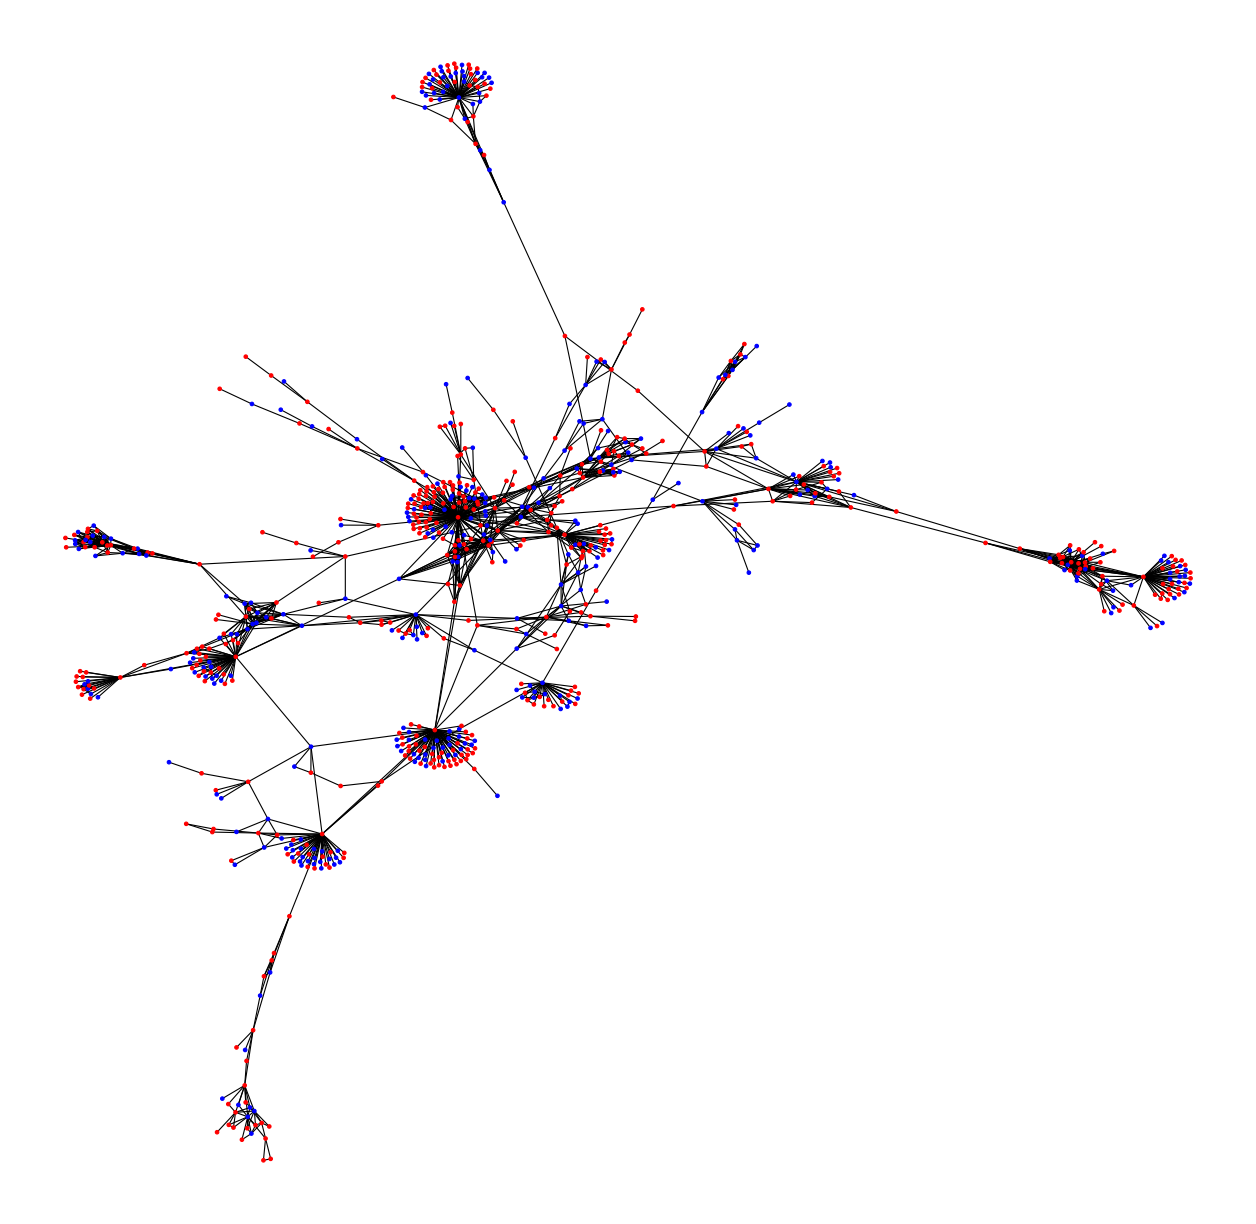

In [28]:
#initialze Figure
plt.figure(num=None, figsize=(20, 20), dpi=80)
plt.axis('off')
fig = plt.figure(1)

# the spectral layout
pos = nx.spring_layout(G, iterations=100)
nx.draw_networkx_labels(G,pos,labels, font_size=13,font_color='green')
nx.draw(G, pos, with_labels = False,node_color = color_map,node_size = size_map)
# nx.draw(G, pos, with_labels = False,node_size = 10)
plt.show() #显示出来

# 原始社交网络

In [89]:
#获取一个Graph对象中node和edge的数量
print("n_nodes",G.number_of_nodes())
print("n_edges",G.number_of_edges())
n_edges = G.number_of_edges()
n_nodes = G.number_of_nodes()
ave_nei = n_edges/n_nodes
print(ave_nei)

#获取一个Graph对象中的node数组或者edge数组
# G.nodes()
# G.edges()

# G.neighbors()   #获取与node为1相邻的node是节点
#     g.remove_edge( 1,2);   #删除node1和node2之间的edge，自此node1和node2不再为相邻的node

n_nodes 811
n_edges 1597
1.969173859432799


In [90]:
node_list = G.nodes()
edge_list = G.edges()

[('U10050', 1), ('U10051', 5), ('U10059', 8), ('U10062', 3), ('U10068', 2), ('U1044', 2), ('U1045', 58), ('U1047', 1), ('U1055', 5), ('U10607', 9), ('U10618', 3), ('U10631', 3), ('U10637', 1), ('U1068', 1), ('U1071', 1), ('U1072', 1), ('U1073', 3), ('U1075', 1), ('U1089', 2), ('U1104', 1), ('U1108', 1), ('U1119', 1), ('U1134', 1), ('U1136', 1), ('U1141', 1), ('U1147', 1), ('U11558', 6), ('U11559', 5), ('U11562', 8), ('U11563', 8), ('U11564', 6), ('U11566', 20), ('U11575', 3), ('U11580', 3), ('U11587', 2), ('U11590', 1), ('U11591', 10), ('U11597', 7), ('U11609', 1), ('U1174', 1), ('U1175', 4), ('U1178', 1), ('U11815', 4), ('U11817', 4), ('U11820', 6), ('U11823', 2), ('U11827', 2), ('U11828', 2), ('U1196', 1), ('U1199', 1), ('U12020', 2), ('U1214', 1), ('U1220', 1), ('U1226', 1), ('U1238', 1), ('U1252', 1), ('U1254', 1), ('U1259', 3), ('U1282', 4), ('U1283', 1), ('U1284', 1), ('U12932', 3), ('U12957', 7), ('U12969', 5), ('U12970', 4), ('U13005', 2), ('U13007', 3), ('U13029', 2), ('U1303'

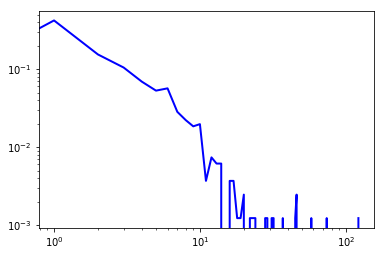

In [102]:
#返回所有节点的度
print(sorted(G.degree()))
#返回图中所有节点的度分布序列（从1至最大度的出现频次）
print(nx.degree_histogram(G))
#返回图中所有节点的度分布序列
degree =  nx.degree_histogram(G)
print(max(G.degree()))
#生成x轴序列，从1到最大度
x = range(len(degree))
#将频次转换为频率
y = [z / float(sum(degree)) for z in degree]
#在双对数坐标轴上绘制度分布曲线
plt.loglog(x,y,color="blue",linewidth=2)
#显示图表
plt.show()

In [104]:
# 平均群聚系数
nx.average_clustering(G)

0.34728772939134467

In [105]:
# 各个节点的群聚系数
nx.clustering(G)

{'U27476': 0.6428571428571429,
 'U4665': 0.5777777777777777,
 'U1313': 0.6666666666666666,
 'U8804': 0,
 'U14078': 0.6666666666666666,
 'U9628': 0.5,
 'U9721': 0,
 'U2649': 0,
 'U27759': 0,
 'U7310': 0,
 'U22859': 0,
 'U1417': 0,
 'U25611': 0.6666666666666666,
 'U24095': 0,
 'U3895': 0.6071428571428571,
 'U13005': 1.0,
 'U2620': 0,
 'U5976': 0.5714285714285714,
 'U4249': 0.2,
 'U9140': 0.6666666666666666,
 'U16112': 1.0,
 'U27776': 0,
 'U27708': 1.0,
 'U15284': 1.0,
 'U24549': 0,
 'U18514': 0.1,
 'U15272': 0.5333333333333333,
 'U3933': 0.3333333333333333,
 'U15946': 0.5333333333333333,
 'U25630': 0.6666666666666666,
 'U25632': 0,
 'U22031': 0,
 'U11562': 0.2857142857142857,
 'U22071': 0,
 'U15292': 0.5277777777777778,
 'U7912': 0.19117647058823528,
 'U22018': 0,
 'U18925': 0,
 'U7136': 0,
 'U14498': 0.5,
 'U21990': 0,
 'U3927': 0,
 'U1381': 0,
 'U22087': 0,
 'U27804': 0,
 'U24252': 0.6666666666666666,
 'U7355': 0.06666666666666667,
 'U12969': 0.4,
 'U2180': 0.7,
 'U11815': 0.6666666666

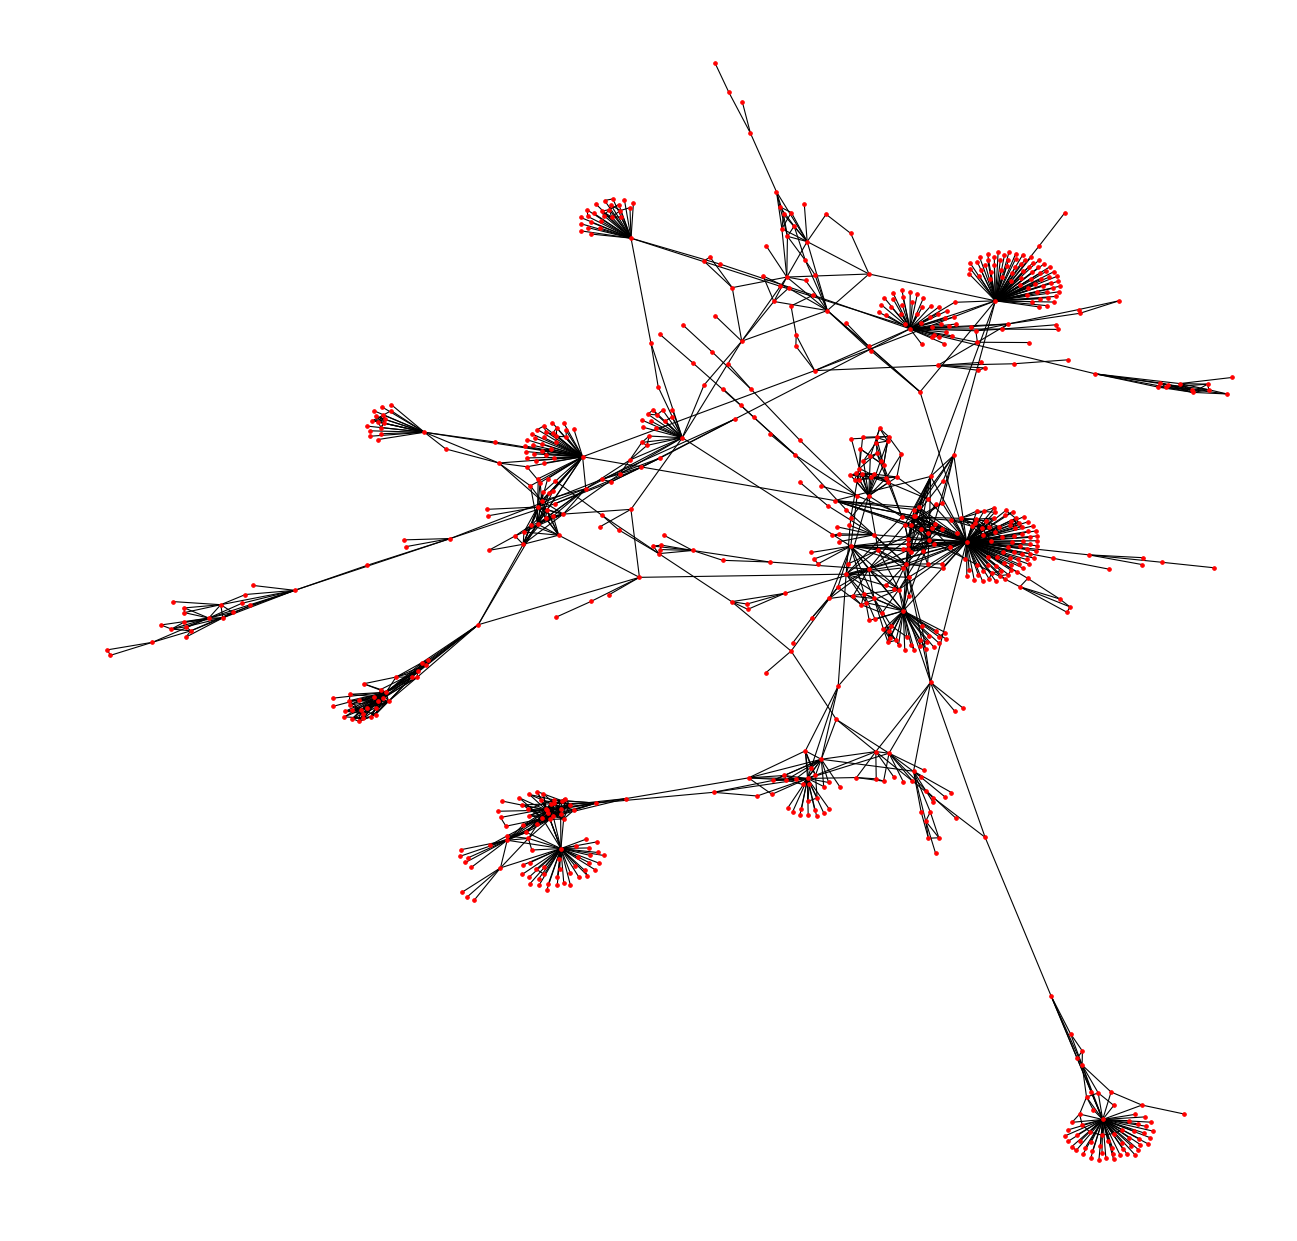

In [75]:
#initialze Figure
plt.figure(num=None, figsize=(20, 20), dpi=80)
plt.axis('off')
fig = plt.figure(1)

# the spectral layout
pos = nx.spring_layout(G, iterations=100)

nx.draw(G, pos, with_labels = False, node_size = 10)
plt.show() #显示出来


Name: 
Type: Graph
Number of nodes: 811
Number of edges: 1597
Average degree:   3.9383
Degree sequence [8, 10, 4, 1, 4, 5, 2, 2, 1, 1, 1, 1, 3, 4, 8, 2, 1, 7, 16, 3, 3, 1, 2, 5, 1, 20, 6, 3, 6, 3, 1, 1, 8, 1, 9, 17, 1, 1, 1, 4, 1, 2, 1, 1, 1, 3, 6, 5, 5, 4, 1, 1, 4, 2, 1, 1, 1, 1, 10, 3, 4, 5, 1, 1, 3, 1, 1, 3, 10, 3, 2, 2, 5, 1, 1, 1, 10, 3, 1, 2, 2, 3, 2, 1, 3, 10, 2, 1, 4, 3, 5, 3, 1, 5, 9, 3, 3, 1, 4, 7, 1, 6, 1, 2, 2, 6, 1, 6, 1, 1, 6, 8, 1, 1, 1, 2, 3, 1, 6, 3, 58, 2, 2, 1, 1, 1, 2, 9, 2, 1, 5, 1, 1, 2, 1, 1, 1, 3, 4, 6, 1, 2, 9, 1, 3, 1, 1, 4, 5, 5, 2, 4, 1, 1, 5, 3, 1, 1, 1, 1, 1, 4, 1, 2, 2, 1, 3, 1, 3, 5, 5, 8, 2, 3, 5, 1, 1, 3, 1, 5, 2, 3, 1, 2, 1, 2, 9, 1, 1, 1, 1, 3, 1, 1, 1, 6, 9, 1, 1, 1, 1, 9, 1, 1, 1, 1, 3, 17, 1, 1, 7, 11, 1, 1, 16, 3, 1, 2, 1, 16, 2, 2, 8, 6, 1, 6, 3, 2, 3, 2, 1, 6, 3, 1, 1, 2, 6, 5, 1, 1, 2, 18, 1, 1, 1, 2, 2, 11, 2, 1, 1, 5, 1, 3, 1, 1, 1, 2, 1, 6, 1, 1, 1, 1, 2, 2, 4, 1, 3, 1, 1, 1, 3, 9, 1, 1, 1, 1, 5, 1, 1, 1, 22, 1, 4, 9, 11, 3, 4, 8, 2, 4, 4, 

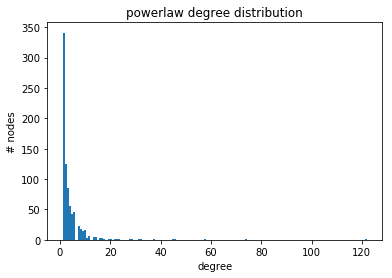

Graph density 0.004862
Diameter (maximum eccentricity): 19
Radius (minimum eccentricity): 10
Mean eccentricity (eccentricity(v) = the maximum distance from v to all other nodes): 13.241676942046857
Center is composed of 3 nodes (nodes with eccentricity equal to radius)
Periphery is composed of 5 nodes (nodes with eccentricity equal to the diameter)
Mean clustering coefficient 0.347288
Total number of triangles in graph: 1217


In [76]:
properties(G)

# 删除边缘节点（degree<2）

In [77]:
n_node_nei = {}
for i in node_list:
    if len([n for n in G.neighbors(i)]) < 2:
#         print(i)
        n_node_nei[i]=[n for n in G.neighbors(i)]
print("----------------------------------------------------------")
# for j in n_node_nei.keys():
#     if len([n for n in G.neighbors(j)]) < 3:
#         print(j)
#         n_node_nei[j]=[n for n in G.neighbors(j)]

# print(n_node_nei)

----------------------------------------------------------


In [78]:
for i in n_node_nei.keys():
        G.remove_node(i)

In [79]:
#获取一个Graph对象中node和edge的数量
print("n_nodes",G.number_of_nodes())
print("n_edges",G.number_of_edges())
n_edges_1 = G.number_of_edges()
n_nodes_1 = G.number_of_nodes()
ave_nei_1 = n_edges_1/n_nodes_1
print(ave_nei_1)

n_nodes 470
n_edges 1256
1.969173859432799


In [80]:
node_list_1 = G.nodes()
edge_list_1 = G.edges()

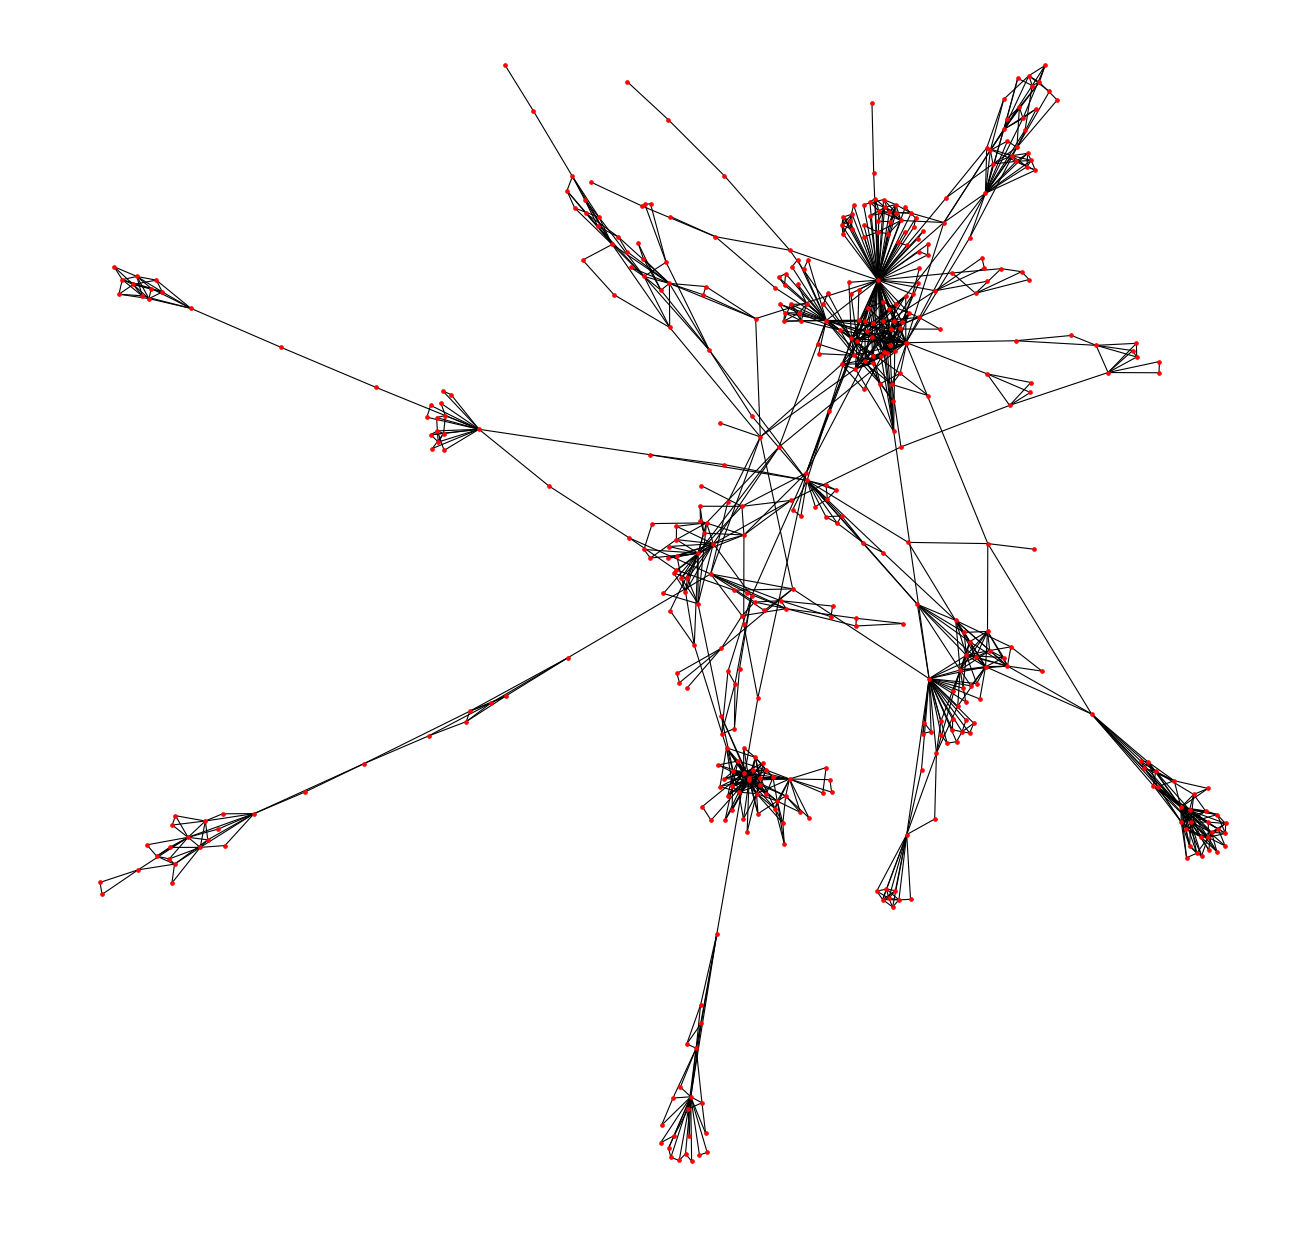

In [81]:
#initialze Figure
plt.figure(num=None, figsize=(20, 20), dpi=80)
plt.axis('off')
fig = plt.figure(1)

# the spectral layout
pos = nx.spring_layout(G, iterations=100)

nx.draw(G, pos, with_labels = False, node_size = 10)
plt.show() #显示出来

Name: 
Type: Graph
Number of nodes: 470
Number of edges: 1256
Average degree:   5.3447
Degree sequence [8, 10, 4, 4, 5, 1, 1, 3, 2, 8, 2, 7, 11, 3, 3, 2, 5, 12, 6, 3, 6, 3, 7, 9, 16, 4, 2, 3, 5, 5, 5, 4, 4, 2, 10, 3, 4, 5, 3, 3, 8, 3, 2, 2, 5, 10, 3, 2, 2, 3, 2, 3, 10, 2, 4, 3, 5, 3, 5, 8, 3, 3, 4, 7, 6, 2, 2, 6, 6, 6, 5, 2, 3, 6, 3, 19, 2, 2, 2, 9, 2, 5, 2, 3, 4, 6, 2, 9, 3, 4, 5, 5, 2, 4, 5, 3, 4, 2, 2, 3, 3, 5, 5, 8, 2, 3, 5, 3, 5, 2, 3, 2, 2, 9, 2, 6, 9, 9, 3, 15, 7, 10, 16, 2, 2, 16, 2, 2, 8, 6, 6, 3, 2, 3, 2, 6, 3, 2, 6, 5, 2, 16, 2, 2, 11, 2, 5, 3, 2, 6, 2, 2, 4, 3, 3, 9, 5, 22, 4, 9, 11, 3, 4, 8, 2, 4, 4, 4, 2, 2, 2, 1, 3, 5, 3, 2, 2, 2, 2, 4, 3, 4, 3, 3, 3, 6, 2, 4, 3, 7, 2, 4, 6, 2, 13, 6, 3, 6, 4, 6, 5, 10, 5, 2, 9, 3, 2, 5, 6, 2, 1, 3, 6, 19, 4, 3, 10, 2, 3, 5, 2, 2, 13, 2, 2, 3, 3, 14, 2, 6, 7, 7, 2, 4, 3, 17, 2, 9, 5, 3, 4, 2, 2, 7, 2, 30, 3, 2, 4, 4, 2, 4, 6, 3, 5, 1, 4, 2, 7, 7, 4, 4, 6, 6, 16, 2, 3, 3, 2, 10, 2, 2, 4, 2, 4, 2, 2, 8, 5, 7, 6, 2, 7, 2, 14, 2, 16, 2, 4, 4

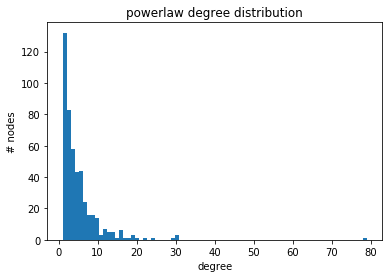

Graph density 0.011396
Diameter (maximum eccentricity): 18
Radius (minimum eccentricity): 10
Mean eccentricity (eccentricity(v) = the maximum distance from v to all other nodes): 12.831914893617022
Center is composed of 10 nodes (nodes with eccentricity equal to radius)
Periphery is composed of 10 nodes (nodes with eccentricity equal to the diameter)
Mean clustering coefficient 0.614339
Total number of triangles in graph: 1217


In [82]:
properties(G)